In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd


In [2]:
# pydf = df.sort_values('id')
# pydf['PY'] = pys
# df = pydf.sort_index()
# df.to_csv('../data/1_predicted_category_documents.csv',index=False)
# #df[['id','content','PY']].head()

In [3]:
df = pd.read_csv('../data/1_predicted_category_documents.csv')


pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]

for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
print(pred_cats)

attrib_cats = [c for c  in df.columns if "2 - " in c and " - mean_prediction" in c and not "12 - " in c]
for c in attrib_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
attrib_cats


df.head()

12442.299999999997
12615.299999999997
9111.599999999999
9360.599999999999
4556.7
4715.700000000001
11711.900000000001
12003.900000000003
29771.3
30213.3
['12 - Coastal and marine Ecosystems - mean_prediction', '12 - Human and managed - mean_prediction', '12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Terrestrial ES - mean_prediction']
41474.9
41911.9
33257.9
33577.9
4545.099999999999
4642.099999999999


,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,random_sample,...,2 - Trend or climate change attribution - upper_pred,2 - 2.4. Sensitivity - mean_prediction,2 - 2.4. Sensitivity - std_prediction,2 - 2.4. Sensitivity - lower_pred,2 - 2.4. Sensitivity - upper_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - mean_prediction,2 - 2.5. Detection of a regional climate trend (no attribution) - std_prediction,2 - 2.5. Detection of a regional climate trend (no attribution) - lower_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - upper_pred,PY
0,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,0.889898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1992.0
1,1,667001,Low-centered ice wedge polygons in the Big Lak...,Field observations of syngenetic ice wedge pol...,syngenetic ice wedge; ice-wedge growth; ice-we...,"['Geosciences, Multidisciplinary']",NaN,0.0,0.0,0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012.0
2,2,780990,Shallow marine ecosystems naturally experience...,Reef calcifiers are adapted to episodic heat s...,NaN,['Multidisciplinary Sciences'],NaN,0.0,0.0,0,...,0.400000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2013.0
3,3,1544528,Trichocomaceae family encompasses the greatest...,DIVERSITY OF ISOLATED Trichocomaceae FROM SOIL...,Trichocomaceae; Pinus elliottii; Corymbia citr...,['Plant Sciences; Forestry'],NaN,0.0,0.0,0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0
4,4,1291826,Climate research in Portugal is often constrai...,High-Resolution Temperature Datasets in Portug...,Climatology; Temperature; Interpolation scheme...,['Meteorology & Atmospheric Sciences'],NaN,0.0,0.0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014.0


In [4]:
places = pd.read_csv('../data/place_df.csv')
places.head()

,word,spans,country_predicted,country_conf,doc_id,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code
0,Barents Sea,"[{'start': 329, 'end': 340}]",NaN,0.904877,1340101,NaN,74.00000,36.00000,NaN,630674.0,Barents Sea,H,SEA
1,East Siberia,"[{'start': 1228, 'end': 1240}]",NaN,0.904877,1340101,NaN,74.00000,166.00000,NaN,2127381.0,East Siberian Sea,H,SEA
2,Gulf Coast,"[{'start': 497, 'end': 507}]",USA,0.904877,222401,Mississippi,29.36901,-95.00565,USA,7287689.0,Gulf Coast,L,AREA
3,San Diego,"[{'start': 114, 'end': 123}]",USA,0.963741,3307272,California,33.02820,-116.77021,USA,5391832.0,San Diego County,A,ADM2
4,Alaska,"[{'start': 91, 'end': 97}]",USA,0.959621,355004,Alaska,64.00028,-150.00028,USA,5879092.0,Alaska,A,ADM1


In [5]:
import pycountry_convert as pc
def get_cont(x):
    continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Oceania',
        'AF': 'Africa',
        'EU': 'Europe'
    }
    try:
        return continents[pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))]
    except:
        return None
places['continent'] = places.apply(lambda x: get_cont(x), axis=1)
other_country_continents = [
    ("ESH","Africa"),
    ("TLS","Oceania"),
    ("XKX","Europe")
    
]
for country,continent in other_country_continents:
    places.loc[places['country_predicted']==country,"continent"] = continent

places.head()


,word,spans,country_predicted,country_conf,doc_id,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,continent
0,Barents Sea,"[{'start': 329, 'end': 340}]",NaN,0.904877,1340101,NaN,74.00000,36.00000,NaN,630674.0,Barents Sea,H,SEA,None
1,East Siberia,"[{'start': 1228, 'end': 1240}]",NaN,0.904877,1340101,NaN,74.00000,166.00000,NaN,2127381.0,East Siberian Sea,H,SEA,None
2,Gulf Coast,"[{'start': 497, 'end': 507}]",USA,0.904877,222401,Mississippi,29.36901,-95.00565,USA,7287689.0,Gulf Coast,L,AREA,North America
3,San Diego,"[{'start': 114, 'end': 123}]",USA,0.963741,3307272,California,33.02820,-116.77021,USA,5391832.0,San Diego County,A,ADM2,North America
4,Alaska,"[{'start': 91, 'end': 97}]",USA,0.959621,355004,Alaska,64.00028,-150.00028,USA,5879092.0,Alaska,A,ADM1,North America


In [6]:
df_places = pd.merge(df,places,left_on="id",right_on="doc_id")
df_places.head()

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,random_sample,...,doc_id,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,continent
0,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,13201,NaN,39.00000,141.00000,JPN,2110769.0,Tōhoku Chihō,L,RGN,Asia
1,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,13201,NaN,35.68536,139.75309,JPN,1861060.0,Japan,A,PCLI,Asia
2,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,13201,NaN,15.50000,101.00000,THA,1605651.0,Kingdom of Thailand,A,PCLI,Asia
3,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,13201,NaN,30.00000,70.00000,NaN,1168579.0,Islamic Republic of Pakistan,A,PCLI,Asia
4,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,13201,Fukushima,37.38158,140.22199,JPN,2112922.0,Fukushima-ken,A,ADM1,Asia


In [7]:
places[pd.isna(places['country_predicted'])].head()

,word,spans,country_predicted,country_conf,doc_id,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,continent
0,Barents Sea,"[{'start': 329, 'end': 340}]",NaN,0.904877,1340101,NaN,74.0,36.00,NaN,630674.0,Barents Sea,H,SEA,None
1,East Siberia,"[{'start': 1228, 'end': 1240}]",NaN,0.904877,1340101,NaN,74.0,166.00,NaN,2127381.0,East Siberian Sea,H,SEA,None
19,Japan Sea,"[{'start': 847, 'end': 856}]",NaN,0.821268,192498,NaN,43.5,135.75,NaN,2038684.0,Sea of Japan,H,SEA,None
23,North Pacific Ocean,"[{'start': 63, 'end': 82}]",NaN,0.852964,792016,NaN,30.0,-170.00,NaN,4030875.0,North Pacific Ocean,H,OCN,None
36,Earth,"[{'start': 437, 'end': 442}]",NaN,0.777676,711757,NaN,0.0,0.00,NaN,6295630.0,Earth,L,AREA,None


In [8]:
places[places['feature_code']=="CONT"].shape

(1345, 14)

In [9]:
# Docs with no places
df[~df['id'].isin(df_places['doc_id'])].shape[0] / df.shape[0]



0.2751782809958714

In [10]:
# Docs with a place and no continent

df[
    (df['id'].isin(df_places.loc[pd.isna(df_places['continent']),'doc_id'])) 
].shape[0] / df.shape[0]

0.10185996079903249

In [11]:
# Doc with a place and a continent

df[
    (df['id'].isin(df_places.loc[~pd.isna(df_places['continent']),'doc_id'])) 
].shape[0] / df.shape[0]



0.6890195587805997

In [12]:

pdf = (df_places.groupby(['PY','continent'])['id']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"id":"N studies"})
      )
pdf.head()

,PY,continent,N studies
15,1991.0,Africa,31
16,1991.0,Asia,110
17,1991.0,Europe,70
18,1991.0,North America,169
19,1991.0,Oceania,21


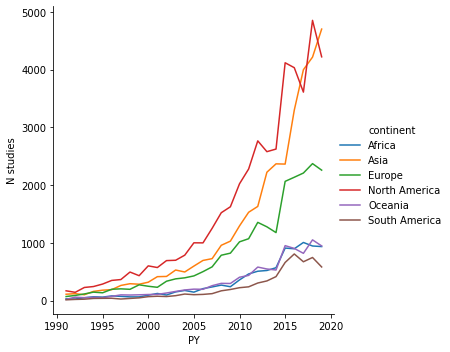

In [13]:
import seaborn as sns
sns.relplot("PY","N studies",hue="continent",data=pdf,kind="line")
plt.savefig('../plots/literature_distribution/PY_continent_n.pdf')

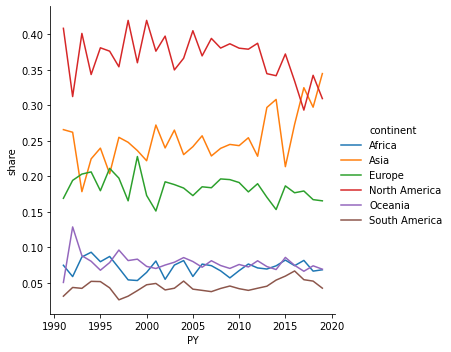

In [14]:
pdf['share'] = pdf['N studies'] / pdf.groupby('PY')['N studies'].transform('sum')

sns.relplot("PY","share",hue="continent",data=pdf,kind="line")
plt.savefig('../plots/literature_distribution/PY_continent_shares.pdf')

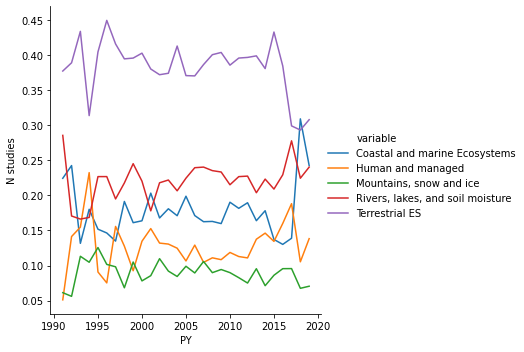

In [15]:
pdf = (df_places[['id','PY']+pred_cats]
       .melt(id_vars=["id","PY"])
       .query('value>0.5')
       .groupby(['PY','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       #.query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )

pdf['N studies'] = pdf['N studies'] / pdf.groupby("PY")['N studies'].transform('sum')
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="variable",data=pdf,kind="line")
plt.savefig("../plots/literature_distribution/PY_continent_attrib.pdf")

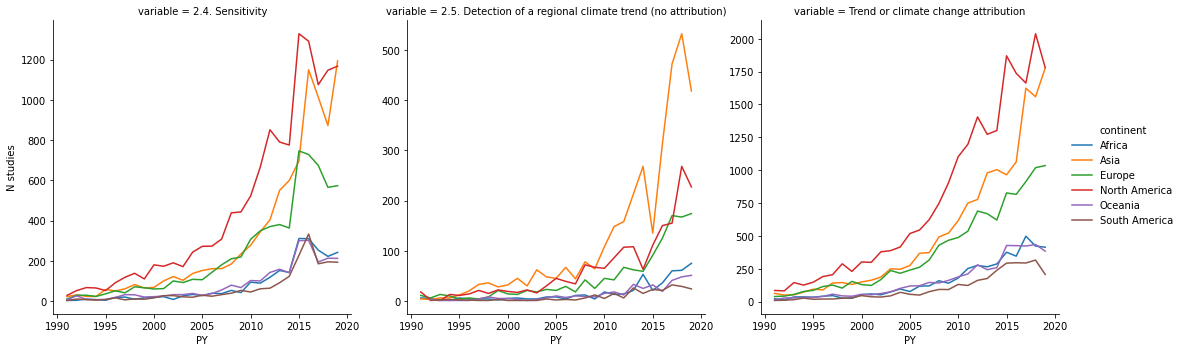

In [16]:
pdf = (df_places[['id','continent','PY']+attrib_cats]
       .melt(id_vars=["id","continent","PY"])
       .query('value>0.5')
       .groupby(['PY','continent','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="continent",data=pdf,col="variable",kind="line",facet_kws={'sharey': False, 'sharex': True})
plt.savefig("../plots/literature_distribution/PY_continent_attrib.pdf")

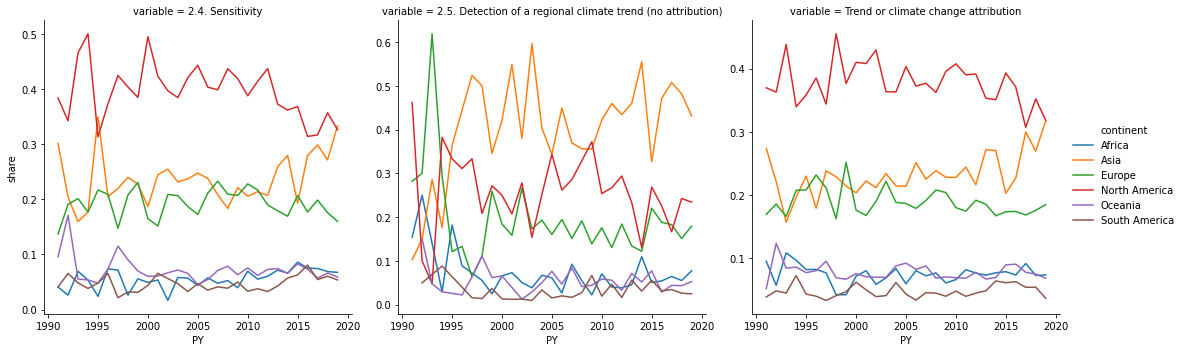

In [17]:
pdf['share'] = pdf['N studies'] / pdf.groupby(['PY','variable'])['N studies'].transform('sum')
sns.relplot("PY","share",hue="continent",data=pdf,col="variable",kind="line",facet_kws={'sharey': False, 'sharex': True})
plt.savefig("../plots/literature_distribution/PY_continent_attrib_share.pdf")

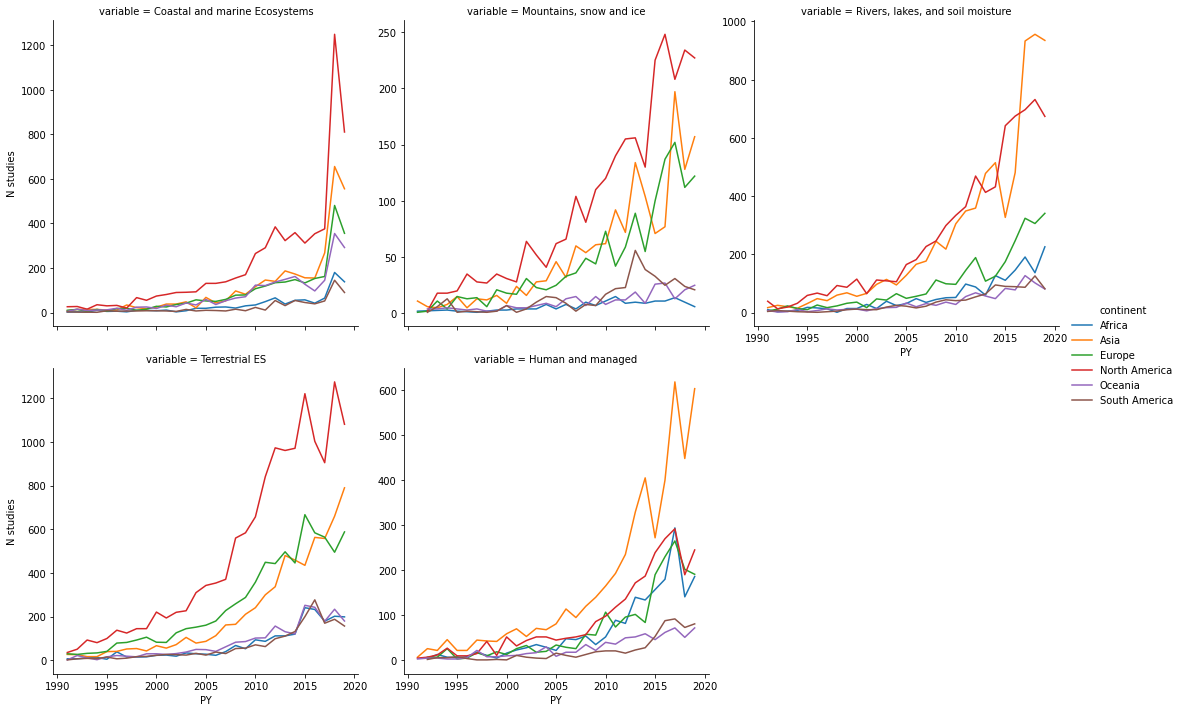

In [18]:
pdf = (df_places[['id','continent','PY']+pred_cats]
       .melt(id_vars=["id","continent","PY"])
       .query('value>0.5')
       .groupby(['PY','continent','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="continent",data=pdf,col="variable", col_wrap=3,kind="line",facet_kws={'sharey': False, 'sharex': True})
plt.savefig("../plots/literature_distribution/PY_continent_impact.pdf")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

[Text(0.5, 0, 'Coastal and marine Ecosystems'),
 Text(1.5, 0, 'Human and managed'),
 Text(2.5, 0, 'Mountains, snow and ice'),
 Text(3.5, 0, 'Rivers, lakes, and soil moisture'),
 Text(4.5, 0, 'Terrestrial ES')]

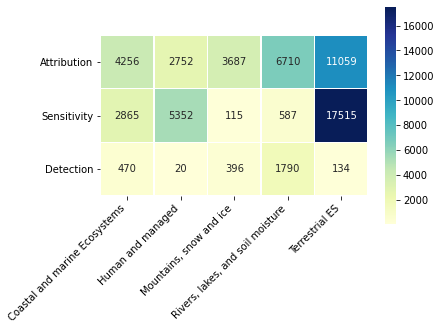

In [19]:
m = np.zeros((len(attrib_cats),len(pred_cats)),int)

for i, ac in enumerate(attrib_cats):
    for j, pc in enumerate(pred_cats):
        df_comb = df.loc[(df[ac]>0.5) & (df[pc]>0.5),]
        df_comb['comb'] = df_comb[ac] + df_comb[pc]         
            
        m[i,j]=df_comb.shape[0]
        
attrib_labels = ["Attribution","Sensitivity","Detection"]
fig, ax = plt.subplots()
sns.heatmap(m,cmap="YlGnBu",ax=ax, linewidths=.5,square=True,annot=True,fmt="d")
ax.set_yticklabels(attrib_labels,rotation=0)
ax.set_xticklabels([x.split(" - ")[1] for x in pred_cats],rotation=45,ha="right")

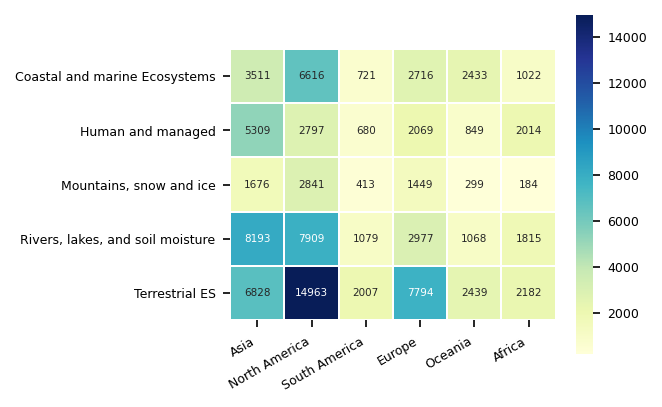

In [28]:
continents = [x for x in df_places.continent.unique() if x is not None]

m = np.zeros((len(pred_cats),len(continents)),int)

for i, cc in enumerate(continents):
    for j, pc in enumerate(pred_cats):
        df_comb = df_places.loc[(df_places["continent"]==cc) & (df_places[pc]>0.5),]          
        m[j,i]=df_comb.shape[0]
        

fig, ax = plt.subplots(figsize=(3.5,3),dpi=150)
sns.heatmap(
    m,cmap="YlGnBu",ax=ax, linewidths=.5,square=True,annot=True,fmt="d", 
    annot_kws={"size":5}
)
ax.set_xticklabels(continents,rotation=30, fontsize=6, ha="right")
ax.set_yticklabels([x.split(" - ")[1] for x in pred_cats],rotation=0,ha="right", fontsize=6)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)


[Text(0, 0.5, 'Mountains, snow and ice'),
 Text(0, 1.5, 'Rivers, lakes, and soil moisture'),
 Text(0, 2.5, 'Coastal and marine Ecosystems'),
 Text(0, 3.5, 'Terrestrial ES'),
 Text(0, 4.5, 'Human and managed')]

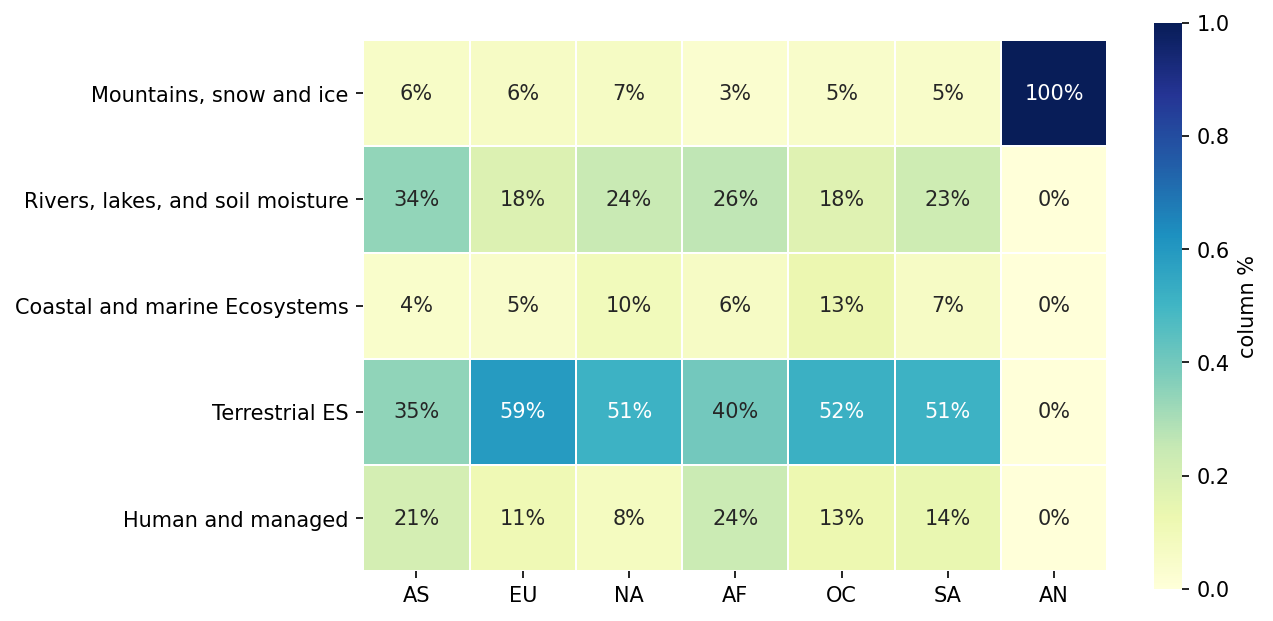

In [50]:
fig, ax = plt.subplots(figsize=(8,5),dpi=150)
sns.heatmap(
    m/m.sum(axis=0),
    cmap="YlGnBu",ax=ax, 
    linewidths=.5,square=True,
    annot=True,fmt=".0%",
    cbar_kws={"label": "column %"}
)
ax.set_xticklabels(continents,rotation=0)
ax.set_yticklabels([x.split(" - ")[1] for x in pred_cats],rotation=0,ha="right")


[Text(0, 0.5, 'Mountains, snow and ice'),
 Text(0, 1.5, 'Rivers, lakes, and soil moisture'),
 Text(0, 2.5, 'Coastal and marine Ecosystems'),
 Text(0, 3.5, 'Terrestrial ES'),
 Text(0, 4.5, 'Human and managed')]

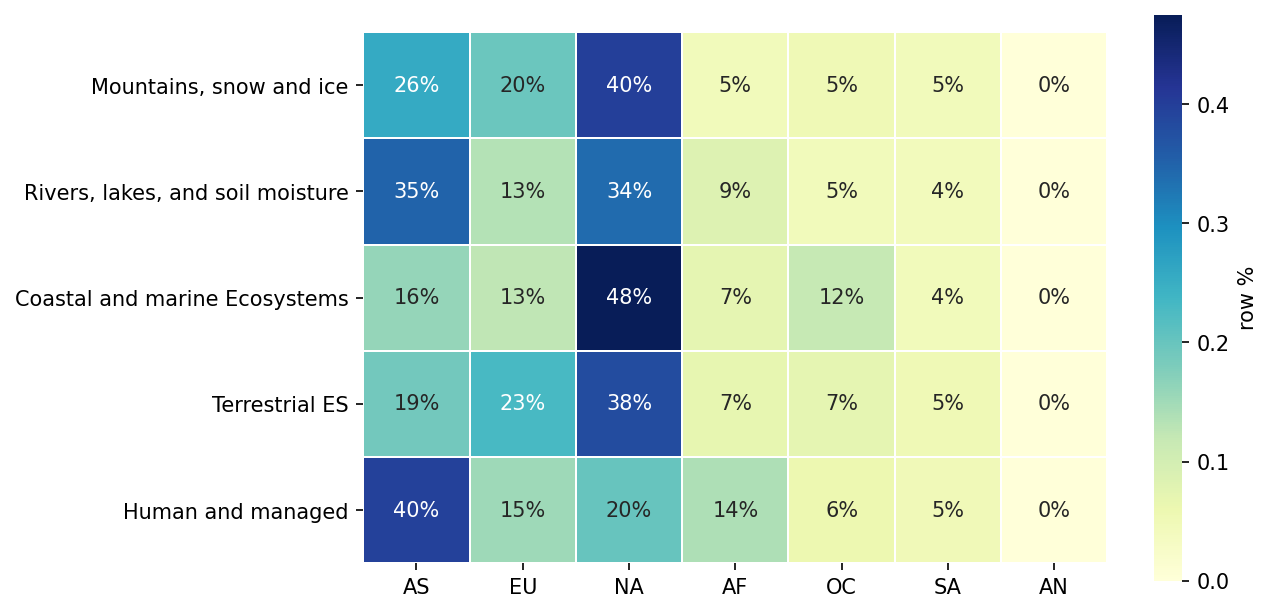

In [51]:
fig, ax = plt.subplots(figsize=(8,5),dpi=150)
sns.heatmap(
    m/m.sum(axis=1,keepdims=True),
    cmap="YlGnBu",ax=ax, 
    linewidths=.5,square=True,
    annot=True,fmt=".0%",
    cbar_kws={"label": "row %"}
)
ax.set_xticklabels(continents,rotation=0)
ax.set_yticklabels([x.split(" - ")[1] for x in pred_cats],rotation=0,ha="right")
